In [1]:
import pandas as pd
import numpy as np


from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load data

data = pd.read_csv("products.csv")
data.tail()

,SKU,Titulo,Marca,Modelo,Preco,Categoria
99,202957200,Geladeira/Refrigerador Consul Cycle Defrost,Consul,Duplex 334L CRD37EBANA Branco,"1.415,41",refr
100,13000100,Geladeira/Refrigerador Consul Frost Free Evox,Consul,Duplex 386L CRM43NKBNA,"2.061,41",refr
101,13075001,Geladeira/Refrigerador Consul Frost Free Duplex,Consul,386L CRM43NBANA Branco,"1.852,41",elgf
102,218039300,Geladeira/Refrigerador Electrolux Frost Free,Electrolux,Duplex 463L Painel Blue Touch TF52 Branco,"2.389,90",elgf
103,217203800,Frigobar Brastemp 76L Azul,Brastemp,Retrô,"1.291,91",rcom


In [3]:
#to classify the data we only use the features 'Titulo' and 'Categoria'
X = data[['Titulo']]
Y = data[['Categoria']]



In [4]:
#categorical variables are often better represented by integers than strings.
Y['category_id'] = Y['Categoria'].factorize()[0]
category_id_df = Y.loc[:,['Categoria', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Categoria']].values)
Y.head()

/home/giovanni/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Categoria,category_id
0,elgf,0
1,reix,1
2,elgf,0
3,elgf,0
4,refr,2


In [5]:
#have to treat the Titulo feature to numeric either
#first calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf
#when we analyze the data we can view some stops words, has e and blank spaces, so to improve the model to classify the phrases remove this words is usefull
stop_word = ['e', '']
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words=stop_word)
features = tfidf.fit_transform(X.values.ravel()).toarray()
labels = Y.category_id
features.shape

(104, 34)

In [6]:
#have to find the terms that are the most correlated with each of the categoria
#it's just to see that one category is related too a title base some words
N = 2
for category, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(category))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'acrf':
  . Most correlated unigrams:
. geladeira
. refrigerador
  . Most correlated bigrams:
. frost free
. geladeira refrigerador
# 'ela1':
  . Most correlated unigrams:
. lava
. seca
  . Most correlated bigrams:
. seca lg
. lava seca
# 'elgf':
  . Most correlated unigrams:
. inox
. duplex
  . Most correlated bigrams:
. free inverse
. free duplex
# 'rcom':
  . Most correlated unigrams:
. brastemp
. frigobar
  . Most correlated bigrams:
. frost free
. geladeira refrigerador
# 'ref2':
  . Most correlated unigrams:
. brastemp
. duplex
  . Most correlated bigrams:
. refrigerador brastemp
. free duplex
# 'refr':
  . Most correlated unigrams:
. consul
. evox
  . Most correlated bigrams:
. refrigerador consul
. free evox
# 'reix':
  . Most correlated unigrams:
. electrolux
. inox
  . Most correlated bigrams:
. refrigerador samsung
. free inox


In [7]:
#split the data into train and test and apply Count Vector and TFIDF to represent the feature as a numeric data
X_train, X_test, y_train, y_test = train_test_split(X, Y['Categoria'], test_size=0.3, random_state=42)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

/home/giovanni/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/giovanni/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/giovanni/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/giovanni/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 membe

                model_name  fold_idx  accuracy
0   RandomForestClassifier         0  0.840000
1   RandomForestClassifier         1  0.913043
2   RandomForestClassifier         2  0.800000
3   RandomForestClassifier         3  0.888889
4   RandomForestClassifier         4  1.000000
5                LinearSVC         0  0.920000
6                LinearSVC         1  0.956522
7                LinearSVC         2  1.000000
8                LinearSVC         3  0.944444
9                LinearSVC         4  1.000000
10           MultinomialNB         0  0.800000
11           MultinomialNB         1  0.826087
12           MultinomialNB         2  0.900000
13           MultinomialNB         3  0.777778
14           MultinomialNB         4  1.000000
15      LogisticRegression         0  0.840000
16      LogisticRegression         1  0.913043
17      LogisticRegression         2  0.950000
18      LogisticRegression         3  0.888889
19      LogisticRegression         4  1.000000


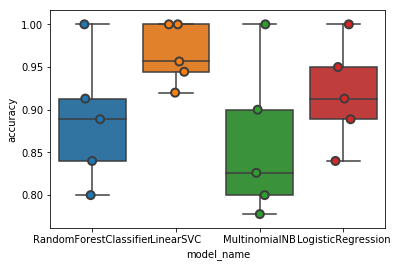

In [8]:
#this select 4 common models used to classify data that already has a category
#so using the 4 models can plot a box-plot of the training score got using  cross validation to obtain the mean
#and the percentiles of the distribution
#based on the chart can choose the best model which has the lowest variation and the mean is next of 1.0


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
print(cv_df)
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

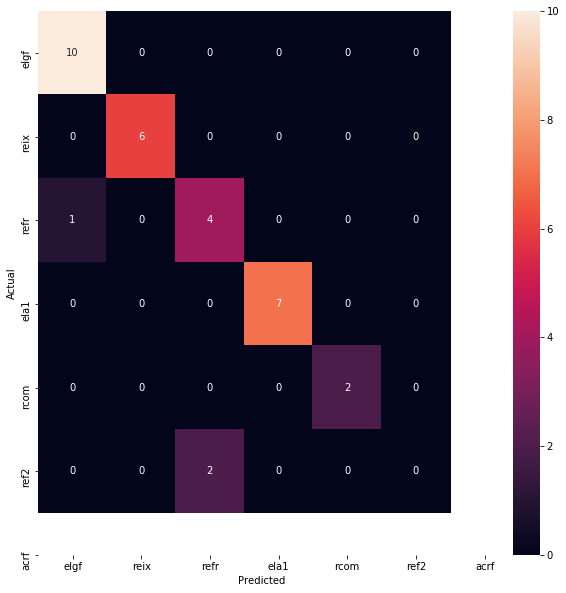

In [9]:
#the image above represente a better model in svc, so let's use csv
#using a confusion matrics can check all the predict data vs the real data value
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, Y.index, test_size=0.3, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Categoria.values, yticklabels=category_id_df.Categoria.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [10]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=Y['Categoria'].unique()))


             precision    recall  f1-score   support

       elgf       0.91      1.00      0.95        10
       reix       1.00      1.00      1.00         6
       refr       0.67      0.80      0.73         5
       ela1       1.00      1.00      1.00         7
       rcom       1.00      1.00      1.00         2
       ref2       0.00      0.00      0.00         2

avg / total       0.86      0.91      0.88        32



/home/giovanni/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1428: UserWarning: labels size, 6, does not match size of target_names, 7
  .format(len(labels), len(target_names))
/home/giovanni/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
print(model.score(X_test, y_test))

0.90625
